In [6]:
import numpy as np
import random
import math

In [7]:
class DuelingBandits:
    def __init__(self, num_arms, win_matrix, best_arm, time_horizon=1e10):
        self.best_arm = best_arm
        self.total_pulls = 0
        self.history = []
        self.time_horizon = time_horizon
        self.regret = 0
        self.num_arms = num_arms
        self.win_matrix = win_matrix  # Win matrix. win_matrix[i][j] is the probability that arm i beats arm j
        self.arms = {i:{'history':[], 'num_pulls':0, 'num_wins':0} for i in range(num_arms)}  # Set of arms
    
    def pull_arms(self, arm_1, arm_2):
        """Simulate pulling the selected arm and receiving a reward."""
        # Updates Globals:
        self.total_pulls += 1

        # Simulate pulling the arms
        if (np.random.binomial(1, self.win_matrix[arm_1, arm_2]+0.5)):
            winning_arm = arm_1
            losing_arm = arm_2
        else: 
            winning_arm = arm_2
            losing_arm = arm_1
        
        # Updates the number of pulls for each arm
        self.arms[arm_1]['num_pulls'] += 1
        self.arms[arm_2]['num_pulls'] += 1

        # Updates the number of wins for each arm
        self.arms[winning_arm]['num_wins'] += 1
        self.arms[losing_arm]['num_wins'] += 0

        # Add to the history of each of the arms:
        self.arms[arm_1]['history'].append({"winner": winning_arm, "loser": losing_arm, "round": self.total_pulls})
        self.arms[arm_2]['history'].append({"winner": winning_arm, "loser": losing_arm, "round": self.total_pulls})

        # Add to the global history
        self.history.append({"winner": winning_arm, "loser": losing_arm, "round": self.total_pulls})
        
        # Update the regret
        self.regret += 0.5 * (self.win_matrix[self.best_arm, losing_arm] + self.win_matrix[self.best_arm, winning_arm])

        return winning_arm
    

In [173]:
# e_i,j = 0.1 for all b_i > b_j (beat the mean example 1)
K = 50 # number of bandits
T = 1e10 # time horizon

Eps = np.zeros((K, K))
for i in range(K):
    for j in range(i+1, K):
        Eps[i, j] = -0.1
        Eps[j, i] = 0.1

In [164]:
def IF1(T, K, bandit):
    # runs interleaved filter 1 over K dueling-bandits with time horizon T
    wins = np.zeros((K, K))
    P_hat = np.ones((K, K))*1/2
    n_rounds = np.zeros((K, K))
    c_hat = np.empty((K, K))
    delta = 1/(T*K**2)
    T_hat = 0 # total comparisons made
    def update(b_1, b_2, res):
        n_rounds[b_1, b_2] = n_rounds[b_1, b_2] + 1
        n_rounds[b_2, b_1] = n_rounds[b_2, b_1] + 1
        wins[b_1, b_2] += res
        wins[b_2, b_1] += (1-res)
        P_hat[b_1, b_2] = wins[b_1, b_2]/n_rounds[b_1, b_2]
        P_hat[b_2, b_1] = wins[b_2, b_1]/n_rounds[b_2, b_1]
        c_hat[b_1, b_2] = math.sqrt(math.log(1/delta)/n_rounds[b_1, b_2])
        c_hat[b_2, b_1] = math.sqrt(math.log(1/delta)/n_rounds[b_2, b_1])

    W = np.arange(0, K)
    b_hat = np.random.choice(K)
    W = np.array(W[~np.isin(W, b_hat)])
    while len(W) > 0:
        for b in W:
            res = bandit.pull_arms(b_hat, b)
            if res == b_hat:
                won = 1
            else:
                won = 0
            T_hat += 1
            update(b_hat, b, won)
        b_to_remove = np.where(np.logical_and(P_hat[b_hat, :] > 1/2, 
            (P_hat[b_hat, :] - c_hat[b_hat, :]) > 1/2))
        W = np.array(W[~np.isin(W, b_to_remove)])
        b_win = np.where(np.logical_and(P_hat[b_hat, :] < 1/2, 
            (P_hat[b_hat, :] + c_hat[b_hat, :]) < 1/2))[0]
        if len(b_win) > 0:
            b_hat = b_win[np.random.choice(len(b_win))]
            W = np.array(W[(~(np.isin(W, b_hat)))])
            wins = np.zeros((K, K))
            P_hat = np.ones((K, K))*1/2
            n_rounds = np.zeros((K, K))
            c_hat = np.empty((K, K))
    
    return (b_hat, T_hat)

In [165]:
bandit = DuelingBandits(K, Eps, K-1, T)
print(IF1(T, K, bandit))

(9, 62211)


In [166]:
def IF2(T, K, bandit):
    # runs interleaved filter 2 over K dueling-bandits with time horizon T
    wins = np.zeros((K, K))
    P_hat = np.ones((K, K))*1/2
    n_rounds = np.zeros((K, K))
    c_hat = np.empty((K, K))
    delta = 1/(T*K**2)
    T_hat = 0 # total comparisons made
    
    def update(b_1, b_2, res):
        #res = 1 if b_1 beat b_2, 0 otherwise
        n_rounds[b_1, b_2] = n_rounds[b_1, b_2] + 1
        n_rounds[b_2, b_1] = n_rounds[b_2, b_1] + 1
        wins[b_1, b_2] += res
        wins[b_2, b_1] += (1-res)
        P_hat[b_1, b_2] = wins[b_1, b_2]/n_rounds[b_1, b_2]
        P_hat[b_2, b_1] = wins[b_2, b_1]/n_rounds[b_2, b_1]
        c_hat[b_1, b_2] = math.sqrt(math.log(1/delta)/n_rounds[b_1, b_2])
        c_hat[b_2, b_1] = math.sqrt(math.log(1/delta)/n_rounds[b_2, b_1])

    W = np.arange(0, K)
    b_hat = np.random.choice(K)
    W = np.array(W[~np.isin(W, b_hat)])
    while len(W) > 0:
        for b in W:
            res = bandit.pull_arms(b_hat, b)
            if res == b_hat:
                won = 1
            else:
                won = 0
            T_hat += 1
            update(b_hat, b, won)
        b_to_remove = np.where(np.logical_and(P_hat[b_hat, :] > 1/2, 
            (P_hat[b_hat, :] - c_hat[b_hat, :]) > 1/2))
        W = np.array(W[~np.isin(W, b_to_remove)])
        b_win = np.where(np.logical_and(P_hat[b_hat, :] < 1/2, 
            (P_hat[b_hat, :] + c_hat[b_hat, :]) < 1/2))[0]
        if len(b_win) > 0:
            # pruning step
            b_to_remove = np.where(P_hat[b_hat, :] > 1/2)
            W = np.array(W[(~(np.isin(W, b_to_remove)))])

            # choose new b_hat from remaining
            b_hat = b_win[np.random.choice(len(b_win))]
            W = np.array(W[(~(np.isin(W, b_hat)))])
            wins = np.zeros((K, K))
            P_hat = np.ones((K, K))*1/2
            n_rounds = np.zeros((K, K))
            c_hat = np.empty((K, K))
    
    return (b_hat, T_hat)

In [167]:
bandit = DuelingBandits(K, Eps, K-1, T)
print(IF2(T, K, bandit))

(9, 28248)


In [171]:
import pdb
def btmb(T, K, bandit):
    # runs beat the mean bandit for K dueling-bandits with time horizon T
    delta = 1/(2*K*T)
    arm_histories = {i:{'history':[]} for i in range(K)} #same as arms, but only add results for b
    
    def confidence(n):
        # returns confidence interval for this many draws
        if n > 1:
            r = math.sqrt(1/n * math.log(1/delta))
        else:
            r = 1
        return r
    
    W = np.arange(0, K)
    num_comp = np.zeros(K)
    num_wins = np.zeros(K)
    P_hat = np.ones(K)*1/2
    # choose random bandit to start with out of those with fewest pulls
    c_star = 1
    t = 0
    while len(W) > 1 and t < T:
        b = W[np.random.choice(np.flatnonzero(num_comp[W] == np.min(num_comp[W])))]
        b_prime = np.random.choice(W[(~(np.isin(W, b)))])
        res = bandit.pull_arms(b, b_prime)
        if res == b:
            losing_arm = b_prime
        else:
            losing_arm = b
        arm_histories[b]['history'].append({"winner": res, "loser": losing_arm})
        num_comp[b] += 1
        c_star = confidence(num_comp[b])
        
        if b == res:
            num_wins[b] += 1
            P_hat[b] = num_wins[b]/num_comp[b] 
        
        t += 1
        if np.min(P_hat[W] + c_star) <= np.max(P_hat[W] - c_star):
            b_prime = W[np.random.choice(np.flatnonzero(P_hat[W] == np.min(P_hat[W])))]
            W = np.array(W[(~(np.isin(W, b_prime)))])
            # remove comparisons with b_prime from num_wins, num_comp
            for b in W:
                losers = np.array([i['loser'] for i in arm_histories[b]['history']])
                num_beat_b_prime = np.sum(losers == b_prime)
                
                winners = [i['winner'] for i in arm_histories[b]['history']]
                num_lost_to_b_prime = np.sum(winners == b_prime)

                num_wins[b] = num_wins[b] - num_beat_b_prime
                num_comp[b] = num_comp[b] - (num_beat_b_prime + num_lost_to_b_prime)
    return W[np.argmax(P_hat[W])]
            
            
            


In [169]:
bandit = DuelingBandits(K, Eps, K-1, T)
print(btmb(T, K, bandit))

removed:  0
removed:  1
removed:  2
removed:  3
removed:  4
removed:  5
removed:  6
removed:  7
removed:  8
[0.39023256 0.38087774 0.3966531  0.3770235  0.39938623 0.41087379
 0.38492063 0.41310212 0.39554318 0.59904535]
9


In [170]:
print(bandit.total_pulls)

40372


In [184]:
IF_1_regret = np.zeros(100)
IF_2_regret = np.zeros(100)
btmb_regret = np.zeros(100)

for K in range(2, 101):
    T = 1e10 # time horizon
    Eps = np.zeros((K, K))
    for i in range(K):
        for j in range(i+1, K):
            Eps[i, j] = -0.1
            Eps[j, i] = 0.1
    
    bandit = DuelingBandits(K, Eps, K-1, T)
    IF1(T, K, bandit)
    IF_1_regret[K-2] = bandit.regret
    
    bandit = DuelingBandits(K, Eps, K-1, T)
    IF2(T, K, bandit)
    IF_2_regret[K-2] = bandit.regret 
    
    bandit = DuelingBandits(K, Eps, K-1, T)
    btmb(T, K, bandit)
    btmb_regret[K-2] = bandit.regret
    print(K)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [185]:
print(IF_1_regret)

[1.2890000e+02 5.1960000e+02 7.0955000e+02 4.3280000e+02 2.1033500e+03
 8.3005000e+02 2.9748000e+03 5.7168500e+03 1.1728500e+03 2.8283000e+03
 5.0981500e+03 7.3973000e+03 3.7843000e+03 4.5564000e+03 8.6912000e+03
 1.1094500e+04 1.0164400e+04 9.4603500e+03 1.2622650e+04 1.1241100e+04
 1.0350200e+04 9.9357000e+03 1.2637050e+04 1.9574900e+04 1.7269450e+04
 1.8036150e+04 2.1452200e+04 8.3043500e+03 2.0411200e+04 1.4715000e+04
 1.7598700e+04 1.7842900e+04 2.4951450e+04 1.8178200e+04 2.8726750e+04
 3.2333750e+04 3.7130450e+04 3.5319650e+04 2.4636300e+04 2.2089400e+04
 2.9604700e+04 3.5965350e+04 2.4032200e+04 3.7241350e+04 3.9806850e+04
 3.2140450e+04 4.2938700e+04 1.7882450e+04 4.1723500e+04 3.4467400e+04
 5.8161350e+04 4.1123950e+04 4.8807300e+04 4.9278650e+04 5.8702100e+04
 2.1686050e+04 5.1785850e+04 5.4234200e+04 2.4965900e+04 4.9464700e+04
 3.4448750e+04 3.0663900e+04 4.6896100e+04 5.9695750e+04 5.7560700e+04
 5.1990800e+04 5.0312500e+04 6.2811850e+04 4.0884750e+04 8.1931250e+04
 4.444

<function matplotlib.pyplot.show(close=None, block=None)>

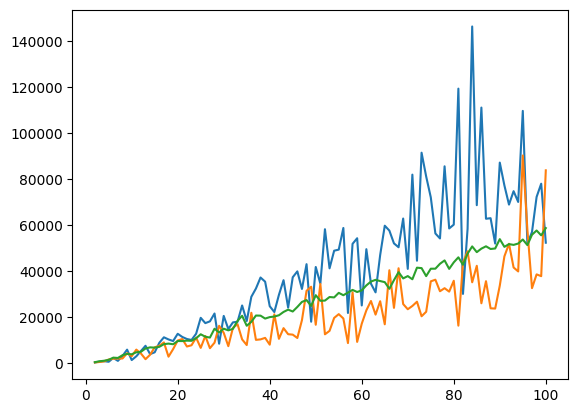

In [195]:
import matplotlib.pyplot as plt
plt.plot(np.arange(2, 101), IF_1_regret[:-1])
plt.show
plt.plot(np.arange(2, 101), IF_2_regret[:-1])
plt.show
plt.plot(np.arange(2, 101), btmb_regret[:-1])
plt.show

(99,)

In [189]:
pip install matplotlib


     |████████████████████████████████| 7.6 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 39.1 MB/s eta 0:00:01
     |████████████████████████████████| 257 kB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 68.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
